In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [23]:
ames_train = pd.read_csv('../datasets/train.csv')
ames_test = pd.read_csv('../datasets/test.csv')

In [24]:
ames_train

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,1,2008,WD,298751
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2009,WD,82500
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,0,NaN,NaN,NaN,0,3,2009,WD,177000
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,144000


To start off with, let's change the column names to a more python-friendly style

In [25]:
ames_train.columns = ames_train.columns.str.lower().str.replace(' ','_')
ames_test.columns = ames_test.columns.str.lower().str.replace(' ','_')

Let's then see what nulls there are

In [26]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

Based on the data dictionary, pool_qc, misc_feature, alley, fence, fireplace_qu, garage_finish, garage_qual, garage_yr_blt, garage_cond, garage_type, bsmt_exposure, bsmtfin_type_2, 1, cond, qual are all encodings of 'Said feature is not present in this house' ex: 'alley' having a value of nan refers to not having alley access from the property. But some of the features, like mas_vnr_area have a 'none' value already encoded, and an extra nan not mentioned in the dictionary (see below for proof)

Therefore, the variables that need a real imputation or removal strategy instead of a method for handling nans as 'none' are: 
'lot_frontage', 'mas_vnr_area', 'mas_vnr_type', 'bsmt_half_bath', 'bsmt_full_bath', 'garage_area', 'total_bsmt_sf', 'bsmt_unf_sf', 'bsmtfin_sf_2', 'bsmtfin_sf_1', 'garage_cars'

In [27]:
ames_train['mas_vnr_type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [28]:
ames_train['lot_frontage'].unique()

array([ nan,  43.,  68.,  73.,  82., 137.,  35.,  70.,  21.,  64., 120.,
        24.,  74.,  93.,  34.,  80.,  71.,  72., 109.,  40., 103., 100.,
        92.,  65.,  75.,  60.,  30.,  79.,  41., 105., 107.,  81.,  36.,
        63.,  32.,  94.,  44.,  50.,  48.,  67.,  88.,  83.,  53.,  58.,
        57.,  52.,  87., 134.,  56.,  54., 140.,  78.,  85.,  90.,  96.,
        62.,  49.,  59., 155.,  91.,  61.,  86., 128.,  77.,  42.,  89.,
        51.,  69.,  55., 112.,  76., 125.,  98., 113., 102.,  22., 122.,
        84., 119., 118.,  66.,  95., 108., 195., 106.,  39., 110., 130.,
        97.,  45.,  37., 123.,  38., 129., 115.,  47., 114., 104.,  46.,
       121., 124., 313., 141., 101.,  99., 160., 174.,  26., 144., 138.,
       111.,  25.,  33., 200., 150., 117., 153., 116., 135.])

ID, PID, are useless for regression/inference, and useless as an index, so we'll just remove those rows

In [29]:
ames_train.drop(columns=['id','pid'], inplace=True)
ames_test.drop(columns=['id','pid'],inplace=True)

In [30]:
ames_train['garage_cars'].unique()

array([ 2.,  1.,  3.,  0.,  4.,  5., nan])

In [31]:
ames_train['bsmtfin_sf_1'].loc[lambda x: np.isnan(x)], ames_train['garage_cars'].loc[lambda x: np.isnan(x)]

(1327   NaN
 Name: bsmtfin_sf_1, dtype: float64,
 1712   NaN
 Name: garage_cars, dtype: float64)

<AxesSubplot:xlabel='garage_qual', ylabel='garage_area'>

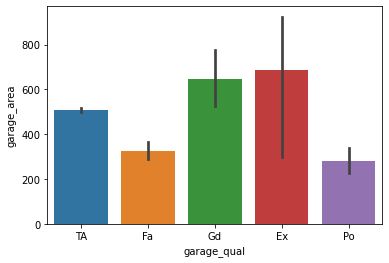

In [32]:
sns.barplot(x=ames_train['garage_qual'],y=ames_train['garage_area'])

Looking at this plot, and with the arrangement of poor to fair to typical to good to excellent, it looks like garage quality is a subjective measure that's highly correlated with garage size- and we want to avoid multicollinearity when creating models. To that effect, we can change garage_qual to simply being something along the lines of 'Is there a garage, yes or no', and keep the garage area. We want to do with the other garage factors- multiplying these variables by using OHE would greatly inflate the feature space without clear benefits- and perhaps lead to overfitting. The following graphs should be taken in that manner

<AxesSubplot:xlabel='garage_finish', ylabel='garage_area'>

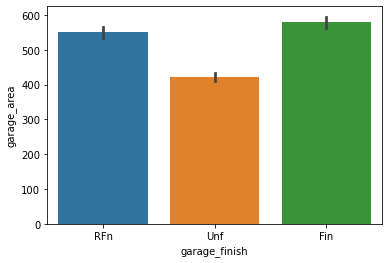

In [33]:
sns.barplot(x=ames_train['garage_finish'],y=ames_train['garage_area'])

<AxesSubplot:xlabel='garage_cond', ylabel='garage_area'>

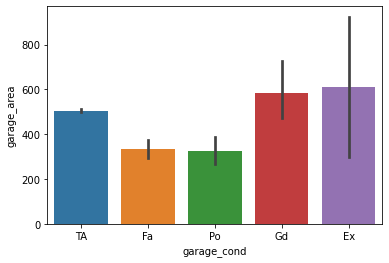

In [34]:
sns.barplot(x=ames_train['garage_cond'],y=ames_train['garage_area'])

<AxesSubplot:xlabel='garage_type', ylabel='garage_area'>

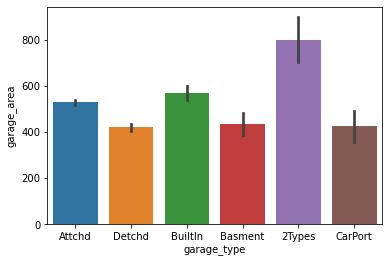

In [35]:
sns.barplot(x=ames_train['garage_type'],y=ames_train['garage_area'])

There's no real ordering pattern to the type, so we'll keep it

<AxesSubplot:xlabel='garage_yr_blt', ylabel='garage_area'>

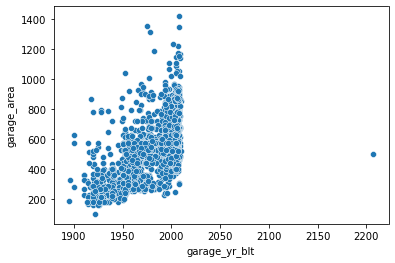

In [36]:
sns.scatterplot(x=ames_train['garage_yr_blt'],y=ames_train['garage_area'])

In [37]:
temp_ames = ames_train.dropna(axis=0, subset=['garage_yr_blt','garage_area'])
np.corrcoef(temp_ames['garage_yr_blt'],temp_ames['garage_area'])

array([[1.        , 0.55206888],
       [0.55206888, 1.        ]])

There's a R**2 of .55, and a rogue yr_blt. We'll keep it in for now, prospectively, and remove the rogue time-traveling garage

In [38]:
ames_train.drop(columns=['garage_qual','garage_finish','garage_cond',], inplace=True)
ames_test.drop(columns=['garage_qual','garage_finish','garage_cond',], inplace=True)

In [41]:
ames_train[(ames_train['garage_yr_blt']<2022) | ames_train['garage_yr_blt'].isnull()].shape


(2050, 76)

In [42]:
ames_train = ames_train[(ames_train['garage_yr_blt']<2022) | ames_train['garage_yr_blt'].isnull()]

similarly, for pools:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pool_qc', ylabel='pool_area'>

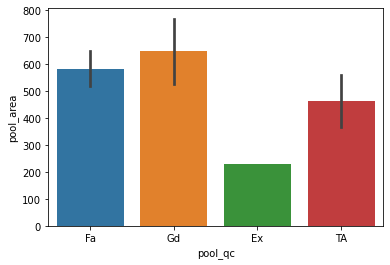

In [18]:
sns.barplot(ames_train['pool_qc'],ames_train['pool_area'])

Perhaps surprisingly, pool quality and pool size do not seem to be related- so we'll fill in the information about no pool, and continue from there

In [62]:
ames_train.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type','bsmt_exposure',
                  'bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']]= ames_train.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type',
                                                                                                 'bsmt_exposure','bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']].fillna('NA')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


'On the primacy of 'Location, location, location''

In [63]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

lot_frontage      330
garage_yr_blt     114
mas_vnr_type       21
mas_vnr_area       21
bsmt_full_bath      2
bsmt_half_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
garage_cars         1
garage_area         1
dtype: int64

In [64]:
ames_test.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type','bsmt_exposure',
                  'bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']]= ames_test.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type',
                                                                                                 'bsmt_exposure','bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']].fillna('NA')

You might have to reconsider this way of doing things

In [67]:
ames_train['garage_yr_blt'].fillna(0,inplace=True)
ames_test['garage_yr_blt'].fillna(0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [68]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

lot_frontage      330
mas_vnr_type       21
mas_vnr_area       21
bsmt_full_bath      2
bsmt_half_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
garage_cars         1
garage_area         1
dtype: int64

In [69]:
ames_train['mas_vnr_type'].fillna('None',inplace=True)
ames_test['mas_vnr_type'].fillna('None',inplace=True)

In [70]:
ames_train['mas_vnr_area'].fillna(0,inplace=True)
ames_test['mas_vnr_area'].fillna(0,inplace=True)